# CoF<sub>2</sub>

In this notebook we further analyze the muon sites of CoF2.

More precisley we will consider:

1. the equivalent positions for the lowest energy sites
2. compare the relaxation function for the nuclear part with the experimental one

The magnetic structure of this system is shown on [Bilbao Crystallographic Server](https://cryst.ehu.es/magndata/index.php?this_label=0.178)

TODOs are highlighted by 🖍️, check instructions and try yourself!

In [1]:
# First we import relevant modules

from pymatgen.core import Structure
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
import numpy as np
from weas_widget import WeasWidget

In [2]:
# This function add atoms in equivalent positions for a given spacegroup
# you don't need to study it, but it's convenient to have in the scripts!
def add_atom_via_asymmetric_unit(
    structure,
    frac_coords,
    species,
    symprec=1e-3
):
    """
    Add an atom by rebuilding the structure from the asymmetric unit
    plus the new atom, using Structure.from_spacegroup.

    Parameters
    ----------
    structure : pymatgen.core.Structure
        Input structure.
    frac_coords : array-like
        Fractional coordinates of the new atom.
    species : str or Element
        Species of the added atom.
    symprec : float
        Symmetry tolerance.

    Returns
    -------
    pymatgen.core.Structure
        Fully symmetrized structure including the new atom.
    """

    sga = SpacegroupAnalyzer(structure, symprec=symprec)
    symm_struct = sga.get_symmetrized_structure()

    spacegroup = sga.get_space_group_symbol()
    lattice = structure.lattice

    # Extract symmetry-inequivalent sites
    species_list = []
    coords_list = []

    for eq_sites in symm_struct.equivalent_sites:
        site = eq_sites[0]
        species_list.append(site.specie)
        coords_list.append(site.frac_coords)

    # Add new atom generator
    species_list.append(species)
    coords_list.append(np.array(frac_coords))

    # Rebuild full structure
    new_structure = Structure.from_spacegroup(
        spacegroup,
        lattice=lattice,
        species=species_list,
        coords=coords_list
    )

    return new_structure

## Summary table

Let's first a second look again at the summary table:

In [3]:
import pandas as pd

df = pd.read_csv("Summary_table.csv")
display(df[['label', 'delta_E', 'muon_position_cc' , 'B_T']])

,label,delta_E,muon_position_cc,B_T
0,A,0,"[0.496, 0.249, 0.0]","[-0.0, 0.0, -0.22]"
1,B,85,"[0.248, 0.002, 0.0]","[-0.0, -0.0, -0.22]"
2,C,85,"[0.251, 0.001, 0.25]","[-0.0, 0.0, 0.22]"
3,D,325,"[0.171, 0.019, 0.14]","[0.124, -0.018, 0.085]"
4,E,325,"[0.268, 0.078, 0.109]","[-0.018, -0.124, -0.085]"
5,F,325,"[0.42, 0.23, 0.11]","[0.124, 0.018, -0.085]"
6,G,402,"[0.172, 0.02, 0.355]","[-0.118, 0.027, 0.081]"
7,H,842,"[0.135, 0.135, 0.248]","[-0.0, -0.0, 0.161]"
8,I,994,"[0.38, 0.12, 0.0]","[-0.0, 0.0, -0.256]"
9,J,1460,"[0.048, 0.048, 0.25]","[0.0, 0.0, 1.089]"


There are many intersting points to notice in this table:
1. many sites have very similar energies and local fields. Although the algorithm does the best it can to find equivalent position we may doubt: are all sites really different?
2. Some coordindates are close to high symmetry points (which one?)
3. Some sites have very large energy!

## Inspect the supercell

The picture below shows the supercell that was computed.

You can show bonds between atoms by changing the search lenght of the function `add_bond_pair`.

Change it so that the F-mu-F site shows up clearly.

In [4]:
viewer = WeasWidget()
viewer.from_pymatgen(Structure.from_file('Supercell_A.cif'))
viewer.avr.model_style = 1
viewer.avr.bond.add_bond_pair('F', 'H', max=0.)  # 🖍️ change `max` in order to show F-H bond
viewer.avr.bond.add_bond_pair('Co', 'F', max=0.) # 🖍️ change `max` in order to show Co-F bond
viewer

WeasWidget(children=(<weas_widget.base_widget.BaseWidget object at 0x7fa5a417c2f0>,))

## Equivalent positions

We obtained an equilibrium position in a supercell. While clearly the muon reduces the symmetry of our lattice, it is usefull to show its position in the initial undistorted cell.

To do so we need to find a mapping between our supercell and the original cell. But these's a problem, **our supercell is distorted by the presence of the muon**.

We'll need a bit of trial and error.

### Finding the original spacegroup

Let's start with the analysis of the unit cell. You can go back to the presentation and check the spacegroup there, but you have two other alternatives:

1. use the file `Allsites_unitcell.cif` that already reports the positions in the undistorted unit cell. 
    You can remove the muons from there and find the spacegroup with a convenient pymatgen function,
    `get_symmetrized_structure()` provided by `SpacegroupAnalyzer`.
2. use the same approach but on the distorted supercell.

In general both approaches give you valuable information to check that everything is consistent.

Let's do both.


In [5]:
# Method 1

CoF2 = Structure.from_file('Allsites_unitcell.cif').remove_species('H')
SpacegroupAnalyzer(CoF2, symprec=0.001).get_symmetrized_structure()

SymmetrizedStructure
Full Formula (Co2 F4)
Reduced Formula: CoF2
Spacegroup: P4_2/mnm (136)
abc   :   4.694100   4.694100   3.169800
angles:  90.000000  90.000000  90.000000
Sites (6)
  #  SP          a        b    c  Wyckoff
---  ----  -------  -------  ---  ---------
  0  Co    0        0          0  2a
  1  F     0.30323  0.30323    0  4f

🧐 Check the result: What spacegroup has been identified? Does it match with your expectations?

In [6]:
# Method 2

CoF2 = Structure.from_file('Supercell_A.cif').remove_species('H')
SpacegroupAnalyzer(CoF2, symprec=0.5).get_symmetrized_structure()  # 🖍️ change the value of `symprec`, what happens? Why?

SymmetrizedStructure
Full Formula (Co16 F32)
Reduced Formula: CoF2
Spacegroup: P4_2/mnm (136)
abc   :   9.388200   9.388200   6.339600
angles:  90.000000  90.000000  90.000000
Sites (48)
  #  SP          a         b        c  Wyckoff
---  ----  -------  --------  -------  ---------
  0  Co    0.99418  0.001315  1e-05    16b
  1  F     0.14731  0.157671  1.1e-05  32g

🧐 Check the result: does it match with your expectations?
If not, why?

**Hint**: try changing how the algorithm checks for equivalent positions. This is governed by `symprec`.

## Mapping positions back to the unit cell

In order to do this we need to know what transformation matrix was used to produce the supercell. This information can be extracted fromt the AiiDA repo, but we find it here just by comparing the initial and the final structures.

To this aim, we will use `StructureMatcher` function of pymatgen.

In [7]:
from pymatgen.analysis.structure_matcher import StructureMatcher

supercell_A = Structure.from_file('Supercell_A.cif')
supercell_A_without_muon = supercell_A.copy().remove_species('H')
CoF2_unitcell = Structure.from_file('Allsites_unitcell.cif').remove_species('H')

# StructureMatcher can accept different tolerances for judging equivalence
matcher = StructureMatcher(primitive_cell=False, attempt_supercell=True)

# first, we can verify these lattices are equivalent
assert(matcher.fit(supercell_A_without_muon,CoF2_unitcell))

# and we can get the transformation matrix from one to the other
# this returns the supercell matrix (e.g. change of basis),
# as well as any relevant translation, and mapping of atoms from one
# crystal to the other
M, T, amap = matcher.get_transformation(supercell_A_without_muon,CoF2_unitcell)

print('Transformation matrix is\n', M)
print('Translation vector is\n', T)

Transformation matrix is
 [[ 2  0  0]
 [ 0  2  0]
 [ 0  0 -2]]
Translation vector is
 [-4.07189944e-03 -1.01144819e-03  1.02276381e-05]


In [14]:
# get index of H in lattice
Hidx = supercell_A.indices_from_symbol('H')

# get its fractional coordinates
H_frac_coords = supercell_A.frac_coords[Hidx]

# Transform it to unit cell
H_frac_coords_unit_cell = ((( H_frac_coords - T) @ M) % 1.)

# print resulting coordinate
print("Fractional coordinates in unit-cell:", H_frac_coords_unit_cell)

Fractional coordinates in unit-cell: [4.61447296e-05 5.00121922e-01 2.30853931e-06]


In the next cell we visualize the result that we just obtained.
🖍️ change the value removing numerical noise. How many sites do you find?

In [9]:
from weas_widget import WeasWidget
viewer = WeasWidget()
viewer.from_pymatgen( add_atom_via_asymmetric_unit(CoF2_unitcell, H_frac_coords_unit_cell, 'H') )
viewer.avr.model_style = 1
viewer.avr.bond.add_bond_pair('F', 'H', max=2.2)
viewer

WeasWidget(children=(<weas_widget.base_widget.BaseWidget object at 0x7fa5a4169090>,))

## What next

At this stage you could:
1. repeat the same analysis for other supercells: can you further reduce the number of inequivalent sites?
2. compute the local fields at the muon site with your favorite tool or with your own code.

Option 2 is given at the end of this tutorial.

# Nuclear relaxation

Experimental muon decay asymmetry A(t) at 70 K in a powdered sampe of CoF<sub>2</sub> have been collected by Johannes S. Moeller and coworkers and are reported in his [Ph.D. thesis](https://ora.ox.ac.uk/objects/uuid:7f19318c-a78e-4499-803b-b93df5ee169a). The results are report below together with a fit described in the thesis.

![](CoF2_FmuF.png)

How does these results compare with our prediction? Can we rule out some sites based on nuclear relaxation rates?

In [10]:
data = np.loadtxt('muon_13_dir_powder_lf.csv',delimiter=',',skiprows=1)

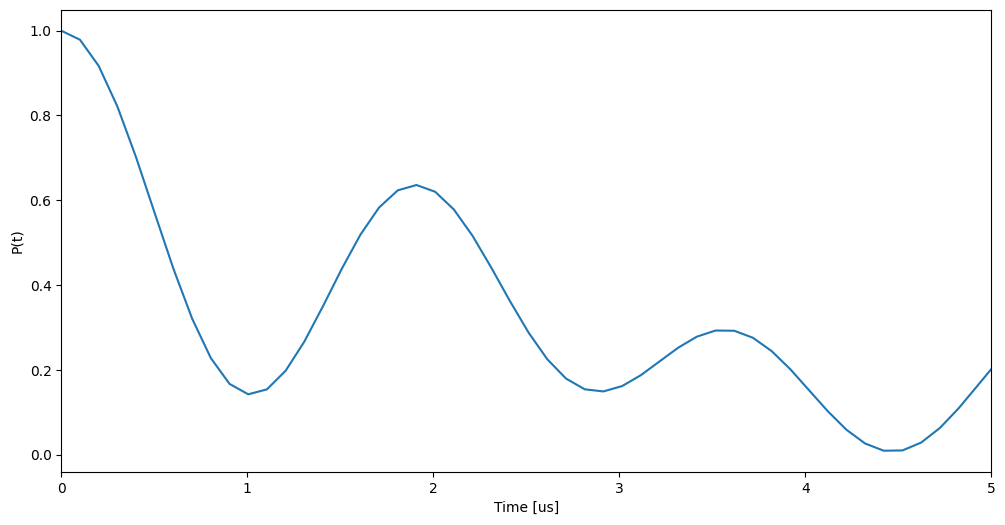

In [17]:
import matplotlib.pyplot as plt
plt.figure(figsize=[12,6])
plt.plot(data[:,1], data[:,2])
plt.xlim(0,5)
plt.xlabel("Time [us]")
plt.ylabel("P(t)");

🤔 Agreement is ok, but not perfect. The peaks are more or less correct, but the relaxation is much faster. Why is that so?

You can go back to the AiiDA interface and check other sites. What is the agreement for the other sites?

# Local fields for equivalent sites

As already pointed out, the equivalent muon sites for supercell A, the lowest energy results, are 4.

In [12]:
add_atom_via_asymmetric_unit(CoF2_unitcell, [xx, yy, zz], 'H') # 🖍️ replace xx, yy, zz with the coordinares of the lowest energy site. 
# Approximate half inter positions to 0.5, how many positions do you get?

NameError: name 'xx' is not defined

### Let's compute the local field at these sites

Manually add the 4 positions below. The magnetic structure has already been defined for you.

In [ ]:
from muesr.core import Sample
from muesr.engines.clfc import find_largest_sphere, locfield
from muesr.i_o import load_cif

cof = Sample()
load_cif(cof,"./CoF2.cif")

# 🖍️ add muon positions, use fractional coordinates (the ones in square brakets reported above) using the syntax below. 
# (if you have problems, solution is given below)
cof.add_muon([xx, yy, zz])


# magnetic moment of 2.6 muB from https:doi.//org/10.1103/PhysRevB.87.121108  https://doi.org/10.1103/PhysRevB.69.014417
cof.new_mm()
cof.mm.k=np.array([0.0,0.0,1.0])
cof.mm.fc= np.array([[0.0, 0.0, 2.6],[0.0, 0.0, -2.6], # the two Co with opposite m
                    [0.0, 0.0, 0.0],[0.0, 0.0, 0.0],   # F
                    [0.0, 0.0, 0.0],[0.0, 0.0, 0.0]], dtype=complex)  # F

# use 100 cells in each direction
n=100
# find the largest sphere contained in this 100x100x100 supercell
radius=find_largest_sphere(cof,[n,n,n])
# compute the local field
r=locfield(cof, 's', [n, n, n] ,radius)

# Finally print the result
for i in range(4):
    print('Site {}, Bdip = {:.4f} T with the experimental value of Bexp = 0.228 T'.format(i, np.linalg.norm(r[i].D,axis=0)))

In [ ]:
# Solution to previous TODO
#cof.add_muon([0.,0.5,0.0])
#cof.add_muon([0.,0.5,0.5])
#cof.add_muon([0.5,0.,0.5])
#cof.add_muon([0.5,0.,0.0])